<a href="https://colab.research.google.com/github/ParkEunHyeok/AI_Study/blob/main/NLP/RNN_NaverShoppingReview_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install konlpy.tag

ERROR: Could not find a version that satisfies the requirement konlpy.tag (from versions: none)
ERROR: No matching distribution found for konlpy.tag


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f8f3f4a2750>)

In [4]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


In [5]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


In [6]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [7]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [8]:
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수 :', len(total_data))

총 샘플의 수 : 199908


In [9]:
print(total_data.isnull().values.any())

False


In [10]:
train_data, test_data = train_test_split(total_data, test_size=0.25, random_state=42)
train_data = train_data[:14000]
test_data = test_data[:5000]
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 14000
테스트용 리뷰의 개수 : 5000


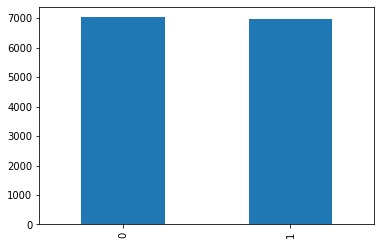

In [11]:
# 레이블의 분포 확인
train_data['label'].value_counts().plot(kind='bar')

In [12]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0   7031
1      1   6969


In [13]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


In [14]:
test_data.drop_duplicates(subset = ['reviews'], inplace=True) # 중복 제거
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['reviews'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 5000


In [15]:
okt = Okt()
print(okt.morphs('와 이런 것도 상품이라고 차라리 내가 만드는 게 나을 뻔'))

['와', '이런', '것', '도', '상품', '이라고', '차라리', '내', '가', '만드는', '게', '나을', '뻔']


In [16]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [17]:
train_data['tokenized'] = train_data['reviews'].apply(okt.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x:
                                                        [item for item in x if item not in stopwords])

In [18]:
test_data['tokenized'] = test_data['reviews'].apply(okt.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x:
                                                      [item for item in x if item not in stopwords])

In [19]:
#단어와 길이 분포 확인하기
negative_words = np.hstack(train_data[train_data.label==0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label==1]['tokenized'].values)

In [20]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('너무', 1234), ('요', 1131), ('안', 1099), ('배송', 896), ('그냥', 804), ('잘', 710), ('했는데', 544), ('별로', 534), ('로', 525), ('못', 491), ('ㅠㅠ', 484), ('제품', 480), ('하고', 472), ('으로', 454), ('좀', 453), ('생각', 442), ('사용', 440), ('만', 417), ('구매', 415), ('개', 405)]


In [23]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('잘', 1373), ('좋아요', 1370), ('배송', 1123), ('너무', 818), ('재구매', 793), ('구매', 731), ('요', 594), ('사용', 514), ('가격', 494), ('제품', 427), ('으로', 406), ('같아요', 406), ('좋네요', 397), ('로', 389), ('빠르고', 378), ('주문', 354), ('보다', 349), ('ㅎㅎ', 349), ('입니다', 342), ('했는데', 329)]


긍정 리뷰의 평균 길어 : 10.799971301477974
부정 리뷰의 평균 길이 : 14.03697909258996


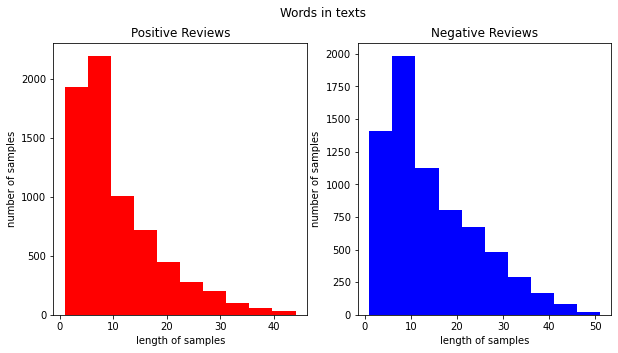

In [28]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길어 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x : len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [30]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [33]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tokenizer.word_counts.items():
  total_freq = total_freq + value

  if(value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value
  
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 24127
등장 빈도가 1번 이하인 희귀 단어의 수: 14032
단어 집합에서 희귀 단어의 비율: 58.15890910598085
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.0662684885519


In [34]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 10097


In [35]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [36]:
print(X_train[:3])

[[33, 1463, 324, 1, 264, 206, 115, 75, 351, 5, 6859, 578, 5, 31, 27, 2229, 714, 406, 82, 6], [3232, 1464, 3233, 3234, 3235, 254, 1, 1], [12, 131, 5233, 287, 1693, 557, 2, 7, 1, 644, 53, 25, 90, 3714, 180, 557, 90, 2, 1, 3715, 3236, 5, 64, 1]]


In [37]:
print(X_test[:3])

[[3, 4281, 741, 1928, 163, 2520], [254, 6256, 27, 4256], [4, 672, 16, 109, 59, 35, 20, 504, 132, 1, 56, 3169, 2, 136]]


리뷰의 최대 길이 : 51
리뷰의 평균 길이 : 12.425642857142858


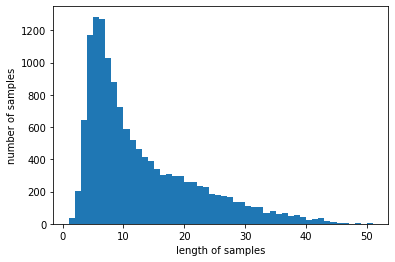

In [38]:
# padding
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [48]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
      cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s' %(max_len, (cnt/len(nested_list))*100))

In [52]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 99.9857142857143


In [53]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [54]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [55]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [57]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [58]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
187/187 [==============================] - 12s 23ms/step - loss: 0.4158 - acc: 0.8203 - val_loss: 0.2979 - val_acc: 0.8825

Epoch 00001: val_acc improved from -inf to 0.88250, saving model to best_model.h5
Epoch 2/15
187/187 [==============================] - 3s 18ms/step - loss: 0.2591 - acc: 0.9052 - val_loss: 0.2928 - val_acc: 0.8975

Epoch 00002: val_acc improved from 0.88250 to 0.89750, saving model to best_model.h5
Epoch 3/15
187/187 [==============================] - 3s 18ms/step - loss: 0.2120 - acc: 0.9229 - val_loss: 0.3014 - val_acc: 0.8918

Epoch 00003: val_acc did not improve from 0.89750
Epoch 4/15
187/187 [==============================] - 3s 19ms/step - loss: 0.1880 - acc: 0.9336 - val_loss: 0.3045 - val_acc: 0.8946

Epoch 00004: val_acc did not improve from 0.89750
Epoch 5/15
187/187 [==============================] - 3s 18ms/step - loss: 0.1673 - acc: 0.9397 - val_loss: 0.2949 - val_acc: 0.8943

Epoch 00005: val_acc did not improve from 0.89750
Epoch 6/15
1

In [63]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

157/157 [==============================] - 1s 6ms/step - loss: 0.2967 - acc: 0.8946

 테스트 정확도: 0.8946


In [64]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))


In [65]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박')

98.59% 확률로 긍정 리뷰입니다.


In [66]:
sentiment_predict('진짜 배송도 늦고 개짜증나네요. 뭐 이런 걸 상품이라고 만듬?')

99.80% 확률로 부정 리뷰입니다.


In [67]:
sentiment_predict('판매자님... 너무 짱이에요.. 대박나삼')

50.13% 확률로 부정 리뷰입니다.


In [68]:
sentiment_predict('ㅁㄴㅇㄻㄴㅇㄻㄴㅇ리뷰쓰기도 귀찮아')

94.15% 확률로 부정 리뷰입니다.
